In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


cuda


### First, we define constants that will be used throughout the notebook
These constants include the target sample index, the corresponding run_path(s) that contains the generated samples for our gflownet method as well as reference methods such as random sampling and RL benchmarks

In [4]:
target_idx = 903
target_mode = "morph"
target_sample_path = f"/home/mila/s/stephen.lu/gfn_gene/res/mmc/targets/sample_{target_idx}.pkl"
runs_dir = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"
save_dir = f"/home/mila/s/stephen.lu/gfn_gene/res/mmc/plots/{target_idx}"
if not os.path.exists(save_dir): os.makedirs(save_dir)
run_paths = {
    "GFN(t=128)": "05-06-06-24-morph-sim-903-high-temp/tough-sweep-2-id-2ao10i82",
    "GFN(t=64)": "05-06-06-21-morph-sim-903-high-temp/solar-sweep-1-id-7mlasa01",
    "GFN(t=32)": "04-30-03-06-morph-sim-run-with-dataset/stoic-sweep-2-id-4kd1wvak",
    "GFN(t=1)": "04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2",
    "RND": "04-30-01-59-morph-sim-run-random-baselines/devoted-sweep-2-id-lipfnja5",
}

### Now, we obtain datum for the target sample as well as for the PUMA dataset, which will be used as reference data for many of our plots
These datum include the target latent representations, the target cluster/assay pred, the PUMA test set samples, PUMA test set cluster/assay preds, assay pred model, cluster pred model, etc.

In [5]:
# Get full PUMA dataset latents, fingerprints, and smiles
datamodule, cfg = setup_puma()
representations = get_representations()
dataset_smis = np.array([x["inputs"]["struct"].mols for x in datamodule.dataset])
dataset_fps = load_puma_dataset_fps(dataset_smis, save_fps=True)

shuffled_scaffold
Train on samples from shuffled_scaffold.


Train on 13568 samples.
Validate on 1696 samples.
Test on 1697 samples.


In [6]:
# Load models and ground truth data
assay_dataset = load_assay_matrix_from_csv()
assay_model = load_assay_pred_model().to(device)
cluster_labels = load_cluster_labels_from_csv()
cluster_model = load_cluster_pred_model(return_ckpt=True)
mmc_model = load_mmc_model(cfg).to(device)

# Load target fingerprint, smiles, latents, active assay cols (if any)
target_smi, target_fp, target_struct_latent, target_morph_latent, target_joint_latent, target_reward =\
    load_target_from_path(target_sample_path, mmc_model, target_mode=target_mode)
target_active_assay_cols = get_active_assay_cols(assay_dataset, target_smi)
target_cluster_id = cluster_labels.loc[target_smi]["Activity"]
target_latent = target_morph_latent if target_mode == "morph" else target_joint_latent
print(target_active_assay_cols, target_cluster_id)

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>


tensor([2]) 8


In [8]:
# Infer target & dataset reward, target assay logits, and target cluster logits
target_latent = target_morph_latent if target_mode == "morph" else target_joint_latent
target_reward = cosine_similarity(target_struct_latent, target_latent)[0][0]
dataset_rewards = ((cosine_similarity(representations['struct'], target_latent) + 1) / 2).reshape(-1,)
dataset_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, dataset_fps))
target_assay_preds = predict_assay_logits_from_smi(None, [target_smi], assay_model, target_active_assay_cols, save_preds=False)
target_active_cluster_pred = predict_cluster_logits_from_smi(None, [target_smi], cluster_model, target_cluster_id, save_preds=False, use_gneprop=True)

print(f"Target struct~{target_mode} alignment: ", target_reward)
print(f"Target assay predicted logits: ", target_assay_preds)
print(f"Target cluster {target_cluster_id} active logit: ", target_active_cluster_pred)

100%|██████████| 1/1 [00:00<00:00, 324.91it/s]


()


Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(1, 100)
()
Target struct~morph alignment:  0.8091377
Target assay predicted logits:  0.9278761
Target cluster 8 active logit:  0.5695883


### Now we load the datum for each run inside run_paths. Datum include the following:
- smiles
- rewards
- fingerprints
- tanimoto similarity to target
- cluster logit predictions (TODO)
- assay logit predictions (for active assay target cols, if any)

We also add the datum for the puma dataset splits into the datum dictionary

In [9]:
runs_datum = {}
for run_name, run_id in run_paths.items():
    run_path = os.path.join(runs_dir, run_id)
    fps, rewards, smis = load_datum_from_run(runs_dir, run_id, remove_duplicates=False)
    tani_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, fps))
    assay_preds = predict_assay_logits_from_smi(run_path, smis, assay_model, target_active_assay_cols)
    cluster_preds = predict_cluster_logits_from_smi(run_path, smis, cluster_model, target_cluster_id, use_gneprop=True)
    run_datum = {
        "path": run_path,
        "fps": fps,
        "rewards": rewards,
        "smis": smis,
        'sim_to_target': tani_sim_to_target,
        'assay_preds': assay_preds,
        'cluster_preds': cluster_preds,
    }
    runs_datum[run_name] = run_datum

131715it [00:00, 432715.93it/s]

640000it [00:01, 448433.17it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-24-morph-sim-903-high-temp/tough-sweep-2-id-2ao10i82/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-24-morph-sim-903-high-temp/tough-sweep-2-id-2ao10i82/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-24-morph-sim-903-high-temp/tough-sweep-2-id-2ao10i82/cluster_preds.npy
(640000,)


640000it [00:01, 456620.42it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-21-morph-sim-903-high-temp/solar-sweep-1-id-7mlasa01/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-21-morph-sim-903-high-temp/solar-sweep-1-id-7mlasa01/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/05-06-06-21-morph-sim-903-high-temp/solar-sweep-1-id-7mlasa01/cluster_preds.npy
(640000,)


640000it [00:01, 442344.25it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-06-morph-sim-run-with-dataset/stoic-sweep-2-id-4kd1wvak/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-06-morph-sim-run-with-dataset/stoic-sweep-2-id-4kd1wvak/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-03-06-morph-sim-run-with-dataset/stoic-sweep-2-id-4kd1wvak/cluster_preds.npy
(640000,)


640000it [00:01, 454287.14it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2/cluster_preds.npy
(640000,)


640000it [00:01, 461467.49it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-01-59-morph-sim-run-random-baselines/devoted-sweep-2-id-lipfnja5/fps.npy!
Loaded assay preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-01-59-morph-sim-run-random-baselines/devoted-sweep-2-id-lipfnja5/assay_preds.npy
(640000,)
Loaded cluster preds from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-01-59-morph-sim-run-random-baselines/devoted-sweep-2-id-lipfnja5/cluster_preds.npy
(640000,)


In [11]:
train_idx, val_idx, test_idx = datamodule.get_split_idx()
dataset_assay_preds = predict_assay_logits_from_smi(None, dataset_smis[test_idx], assay_model, target_active_assay_cols, save_preds=False)
dataset_cluster_preds = predict_cluster_logits_from_smi(None, dataset_smis[test_idx], cluster_model, target_cluster_id, save_preds=False, use_gneprop=True)
# runs_datum['PUMA_tr'] = {
#     "fps": [dataset_fps[i] for i in train_idx],
#     "rewards": dataset_rewards[train_idx],
#     "smis": dataset_smis[train_idx],
#     "sim_to_target": dataset_sim_to_target[train_idx],
#     "cluster_preds": dataset_cluster_preds[train_idx],
#     "assay_preds": dataset_assay_preds[train_idx] if len(target_active_assay_cols) == 1 else dataset_assay_preds[train_idx,:],
# }
# runs_datum['PUMA_val'] = {
#     "fps": [dataset_fps[i] for i in val_idx],
#     "rewards": dataset_rewards[val_idx],
#     "smis": dataset_smis[val_idx],
#     'sim_to_target': dataset_sim_to_target[val_idx],
#     "cluster_preds": dataset_cluster_preds[val_idx],
#     "assay_preds": dataset_assay_preds[val_idx] if len(target_active_assay_cols) == 1 else dataset_assay_preds[val_idx,:],
# }
runs_datum['PUMA_test'] = {
    "fps": [dataset_fps[i] for i in test_idx],
    "rewards": dataset_rewards[test_idx],
    "smis": dataset_smis[test_idx],
    'sim_to_target': dataset_sim_to_target[test_idx],
    "cluster_preds": dataset_cluster_preds,
    "assay_preds": dataset_assay_preds if len(target_active_assay_cols) == 1 else None,
}

 29%|██▊       | 4/14 [00:00<00:00, 11.89it/s]

100%|██████████| 14/14 [00:01<00:00, 12.77it/s]


(1697,)


Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(1697, 100)
(1697,)


# Plots
## 1. Reward, Tanimoto Similarity, and UMAP plots
In this first section, we produce plots that don't require an additional oracle. These include:
- Number of modes over number of trajectories during training
- Number of unique scaffolds over number of trajectories during training (currently takes v long)
- Tanimoto similarity between top-k highest reward molecules during training
- Tanimoto similarity to target of top-k modes during training
- Normalized histogram of rewards for generated samples during training
- Normalized histogram of Tanimoto similarity to target for training samples
- UMAP of top-k modes coloured (more intensely) by reward obtained during training
- Normalized violin plot of Tanimoto similarity to target by binned reward
- Normalized violin plot of reward by binned Tanimoto similarity to target

100%|██████████| 10000/10000 [00:00<00:00, 22473.98it/s]


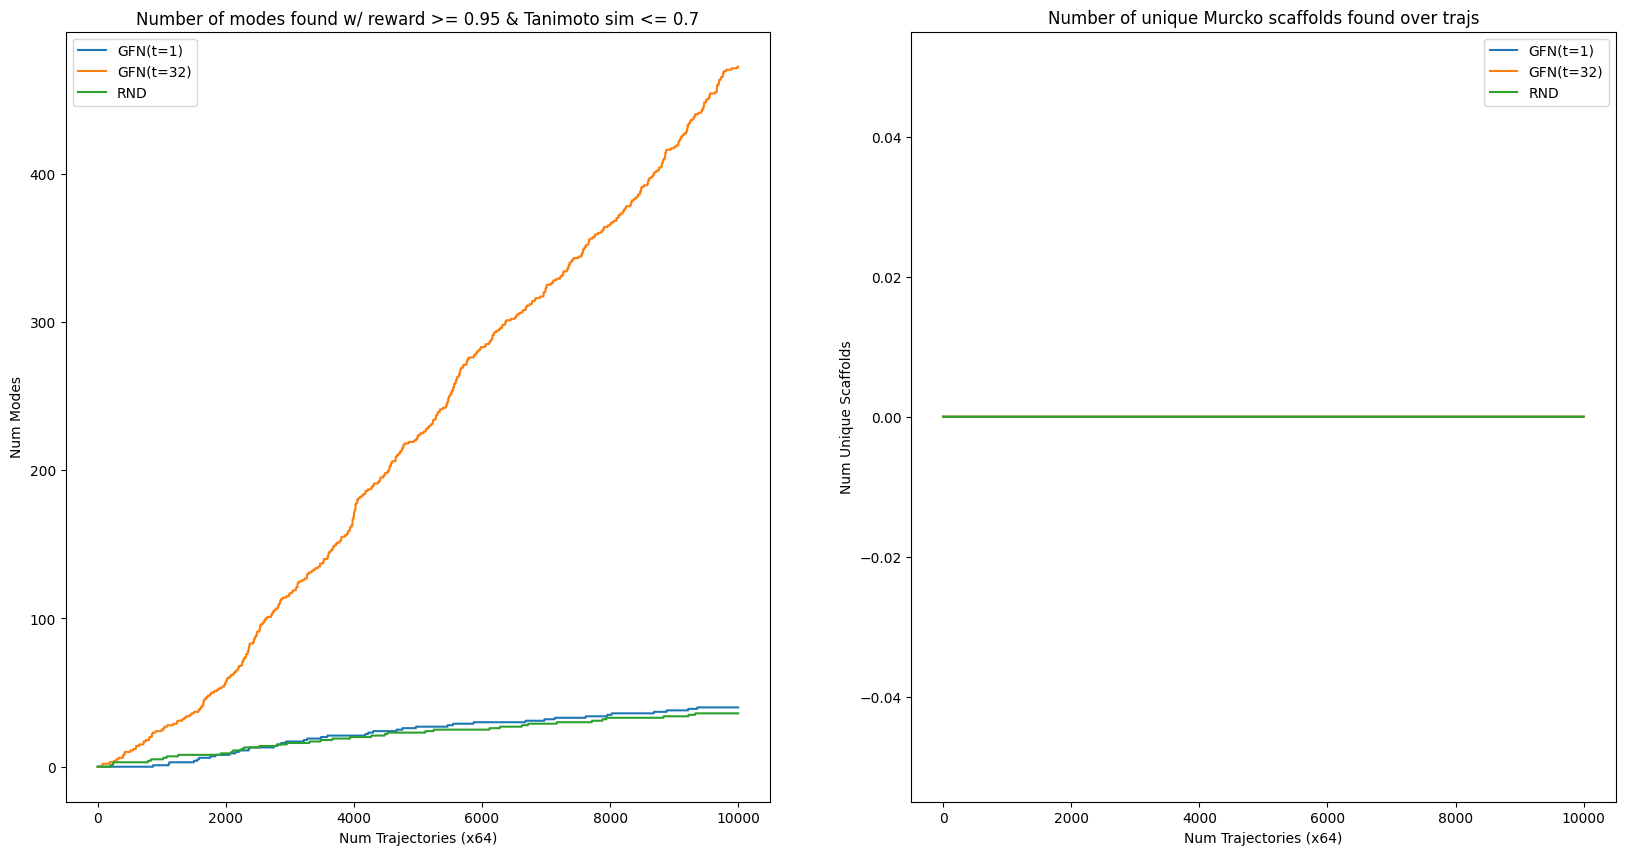

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for run_name, run_datum in runs_datum.items():
    if "PUMA" in run_name: continue
    num_modes, num_scafs = num_modes_over_trajs(run_datum, rew_thresh=0.95, sim_thresh=0.7, batch_size=64)
    sns.lineplot(x=np.arange(len(num_modes)), y=num_modes, ax=ax[0], label=run_name)
    sns.lineplot(x=np.arange(len(num_scafs)), y=num_scafs, ax=ax[1], label=run_name)

ax[0].set_title("Number of modes found w/ reward >= 0.95 & Tanimoto sim <= 0.7")
ax[1].set_title("Number of unique Murcko scaffolds found over trajs")
ax[0].set_xlabel("Num Trajectories (x64)")
ax[1].set_xlabel("Num Trajectories (x64)")
ax[0].set_ylabel("Num Modes")
ax[1].set_ylabel("Num Unique Scaffolds")
plt.legend()
plt.savefig(f"{save_dir}/num_modes_scafs.png")
plt.show()

### These are the only plots that require all molecules sampled during training. We can now subset to remove duplicates for the further analyses
This might take some time since we are converting all arrays to numpy arrays

In [12]:
runs_datum = {k: remove_duplicates_from_run(v) for k, v in runs_datum.items()}

cuda
Removed 318491 duplicates
Removed 148968 duplicates
Removed 69264 duplicates
Removed 18173 duplicates
Removed 310412 duplicates
Removed 0 duplicates


100%|██████████| 1000/1000 [00:00<00:00, 7696.80it/s]


100%|██████████| 1000/1000 [00:00<00:00, 9872.39it/s]


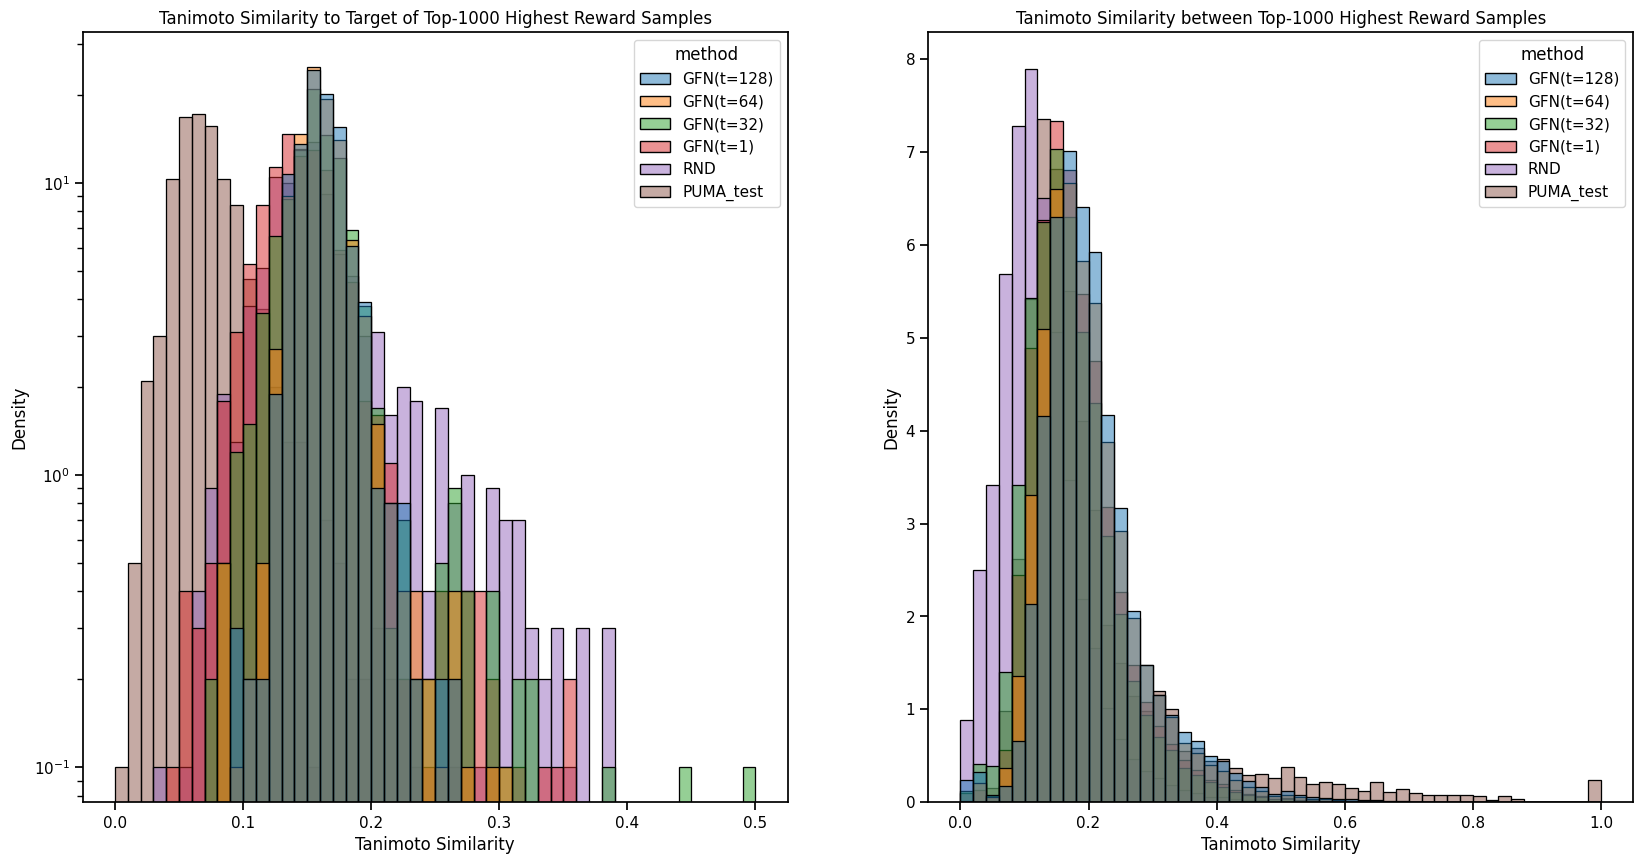

In [13]:
k = 1000
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
df1, df2 = pd.DataFrame(), pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    modes_idx = np.argsort(run_datum['rewards'])[::-1][:k]
    top_k_rewards_idx = np.argsort(run_datum['rewards'][modes_idx])[::-1][:k]
    modes_fps = [run_datum['fps'][i] for i in top_k_rewards_idx]
    tani_sim_between_modes = []
    for i in tqdm(range(len(modes_fps))):
        tani_sim_between_modes.extend(AllChem.DataStructs.BulkTanimotoSimilarity(modes_fps[i], modes_fps[i+1:]))

    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(modes_idx),
        "sim_to_target": run_datum['sim_to_target'][modes_idx]
    })], ignore_index=True)
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(tani_sim_between_modes),
        "sim_between_modes": tani_sim_between_modes
    })], ignore_index=True)

sns.histplot(data=df1, x="sim_to_target", hue="method", bins=50, ax=ax[0], stat="density", common_norm=False, alpha=0.5)
sns.histplot(data=df2, x="sim_between_modes", hue="method", bins=50, ax=ax[1], stat="density", common_norm=False, alpha=0.5)
    
ax[0].set_title(f"Tanimoto Similarity to Target of Top-{k} Highest Reward Samples")
ax[0].set_xlabel("Tanimoto Similarity")
ax[1].set_title(f"Tanimoto Similarity between Top-{k} Highest Reward Samples")
ax[1].set_xlabel("Tanimoto Similarity")
ax[0].set_yscale('log', base=10)

# plt.savefig(f"{save_dir}/tanimoto_sim.png")
plt.show()

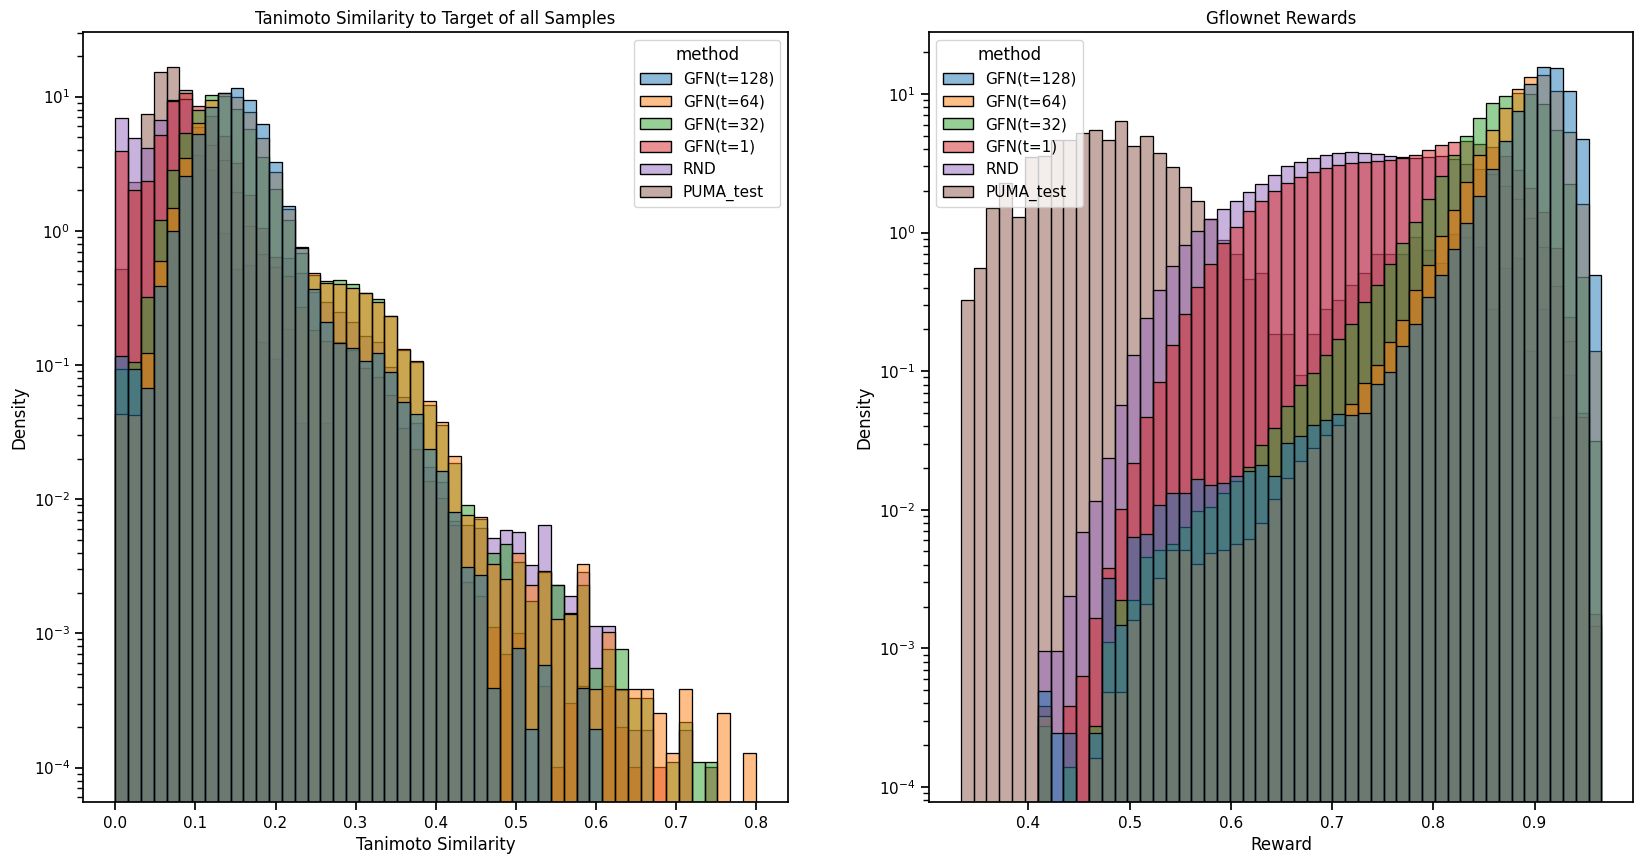

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
df = pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    df = pd.concat([df, pd.DataFrame({
        "method": [run_name] * len(run_datum['rewards']),
        "rewards": run_datum['rewards'],
        "sim_to_target": run_datum['sim_to_target']
    })], ignore_index=True)

sns.histplot(data=df, x="sim_to_target", hue="method", bins=50, ax=ax[0], stat='density', common_norm=False)
sns.histplot(data=df, x="rewards", hue="method", bins=50, ax=ax[1], stat='density', common_norm=False)

ax[0].set_title("Tanimoto Similarity to Target of all Samples")
ax[1].set_title("Gflownet Rewards")
ax[0].set_xlabel("Tanimoto Similarity")
ax[1].set_xlabel("Reward")
ax[0].set_yscale('log')
ax[1].set_yscale('log')

# plt.savefig(f"{save_dir}/sim_rewards_all_samples.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
k = 5000
df1, df2 = pd.DataFrame(), pd.DataFrame()
# look at max_dist parameter
model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42, verbose=False, min_dist=0.01, metric="euclidean")
max_reward = max([max(run_datum['rewards']) for run_datum in runs_datum.values()])
min_reward = min([min(run_datum['rewards']) for run_datum in runs_datum.values()])
norm_color_by_reward = lambda x: ((x - min_reward) / (max_reward - min_reward))**4
target_color = norm_color_by_reward(target_reward)

for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_tr", "PUMA_val", "PUMA_test"]: continue
    rewards = run_datum['rewards']
    if run_name == "PUMA_test":
        top_k_modes_idx = np.arange(len(run_datum['fps']))
        top_k_rewards_idx = np.arange(len(run_datum['fps']))
    else:
        top_k_modes_idx = find_modes_from_run_datum(run_datum, sim_threshold=0.7, k=k)
        top_k_rewards_idx = np.argsort(rewards)[::-1][:k]

    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(top_k_modes_idx),
        "fps": [run_datum['fps'][i] for i in top_k_modes_idx],
        "rewards": rewards[top_k_modes_idx],
        "alpha": list(map(norm_color_by_reward, rewards[top_k_modes_idx])),
    })], ignore_index=True)
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(top_k_rewards_idx),
        "fps": [run_datum['fps'][i] for i in top_k_rewards_idx],
        "rewards": rewards[top_k_rewards_idx],
        "alpha": list(map(norm_color_by_reward, rewards[top_k_rewards_idx])),
    })], ignore_index=True)

umap_top_modes = model.fit_transform(list(df1["fps"]))
target_umap = model.transform([target_fp])
df1["umap_0"], df1["umap_1"] = umap_top_modes[:,0], umap_top_modes[:,1]
sns.scatterplot(data=df1, x="umap_0", y="umap_1", hue="method", ax=ax[0], alpha=0.5)
sns.scatterplot(x=target_umap[:, 0], y=target_umap[:, 1], ax=ax[0], label="Target", color="black", s=100, alpha=target_color)

umap_top_rewards = model.fit_transform(list(df2["fps"]))
target_umap = model.transform([target_fp])
df2["umap_0"], df2["umap_1"] = umap_top_rewards[:,0], umap_top_rewards[:,1]
sns.scatterplot(data=df2, x="umap_0", y="umap_1", hue="method", ax=ax[1], alpha=0.5)
sns.scatterplot(x=target_umap[:, 0], y=target_umap[:, 1], ax=ax[1], label="Target", color="black", s=100, alpha=target_color)

ax[0].set_title(f"UMAP of Top-{k} modes")
ax[1].set_title(f"UMAP of Top-{k} samples by reward")
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")
ax[1].set_xlabel("UMAP 1")
ax[1].set_ylabel("UMAP 2")

# add a colorbar that maps the reward to the color using the lambda function we defined above
norm = Normalize(vmin=min_reward, vmax=max_reward)
reward_to_rgba = lambda x: (0, 0, 0, norm_color_by_reward(x))
colors = [reward_to_rgba(norm(x)) for x in np.linspace(min_reward, max_reward, 100)]
cmap = LinearSegmentedColormap.from_list('reward_cmap', colors)

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax[1], location="right")
cbar.set_label('Reward')

plt.tight_layout()
plt.show()

Binning rewards into 15 bins between 0.33327290415763855 and 0.9659846425056458: 
Bins: [0.3332729  0.3784666  0.4236603  0.46885399 0.51404769 0.55924138
 0.60443508 0.64962877 0.69482247 0.74001616 0.78520986 0.83040356
 0.87559725 0.92079095 0.96598464]
Sampling 1000 samples per method per bin
Binning sim_to_target into 15 bins between 0.0 and 0.8: 
Bins: [0.         0.05714286 0.11428571 0.17142857 0.22857143 0.28571429
 0.34285714 0.4        0.45714286 0.51428571 0.57142857 0.62857143
 0.68571429 0.74285714 0.8       ]
Sampling 1000 samples per method per bin


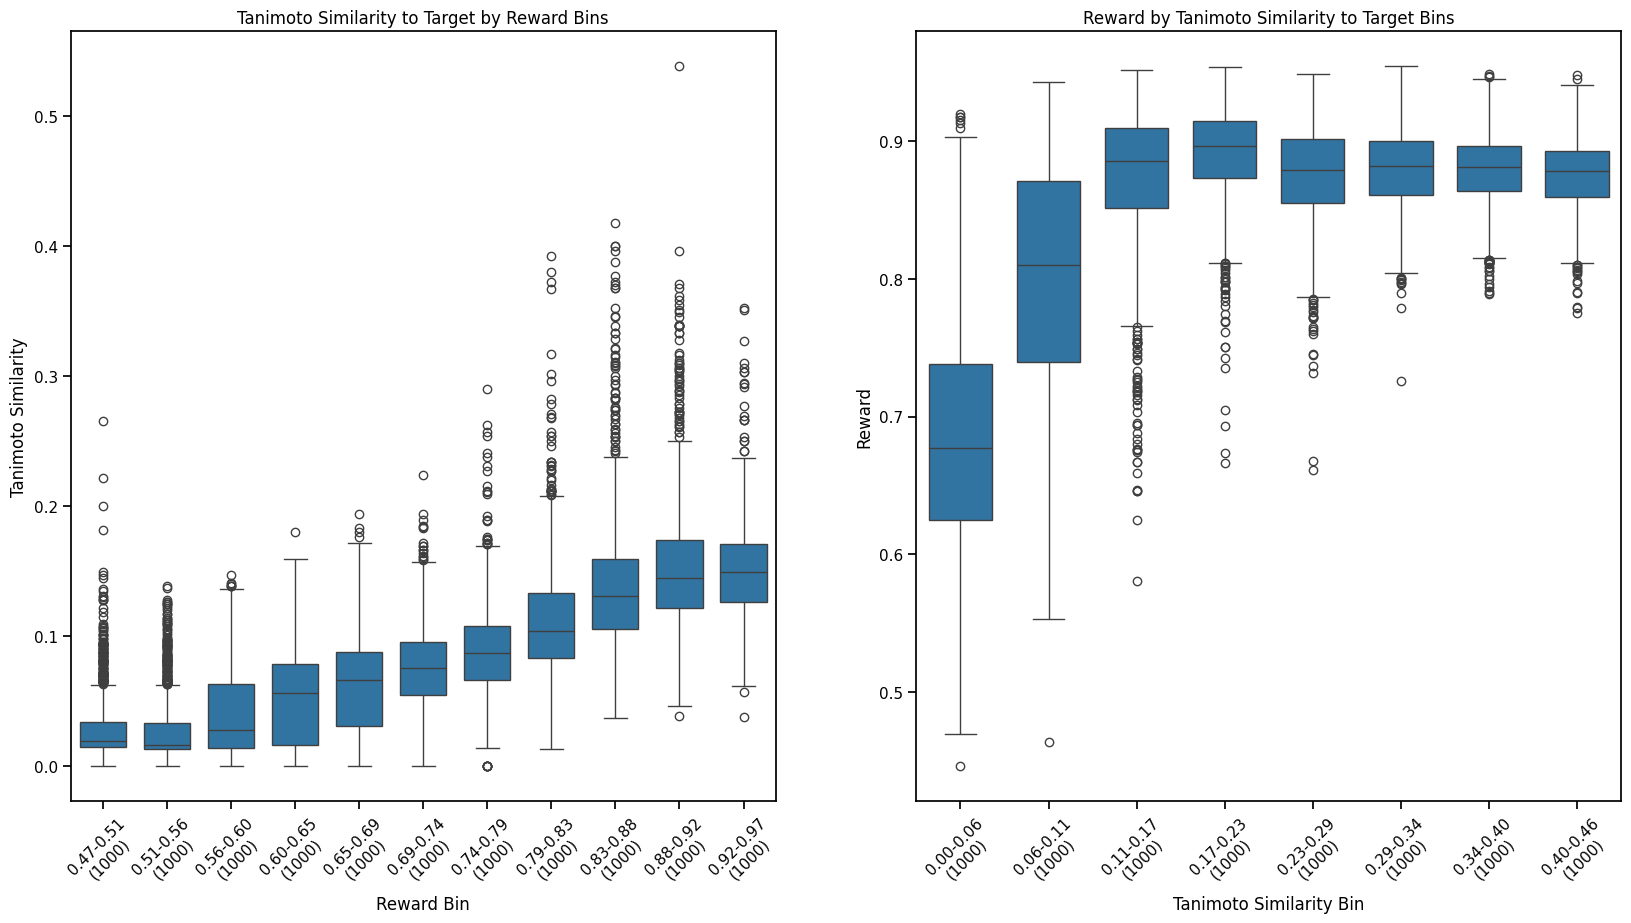

In [15]:
# Create a pooled datum where we merge the datum for each run under a new key called 'pooled'
pooled_datum = pool_datum(runs_datum, avoid_keys=["PUMA_tr", "PUMA_val"])
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col(
    "rewards", pooled_datum, 15, return_bins=True, samples_per_method=1000, toss_bins_with_less_methods=True)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col(
    "sim_to_target", pooled_datum, 15, return_bins=True, samples_per_method=1000, toss_bins_with_less_methods=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    # df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_ne)]
rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sns.boxplot(x="Bin", y="sim_to_target", data=global_df_by_rew, ax=ax[0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    # df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_ne)]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]
sns.boxplot(x="Bin", y="rewards", data=global_df_by_sim, ax=ax[1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0].set_title("Tanimoto Similarity to Target by Reward Bins")
ax[0].set_xlabel("Reward Bin")
ax[0].set_ylabel("Tanimoto Similarity")
ax[0].xaxis.set_tick_params(rotation=45)

ax[1].set_title("Reward by Tanimoto Similarity to Target Bins")
ax[1].set_xlabel("Tanimoto Similarity Bin")
ax[1].set_ylabel("Reward")
ax[1].xaxis.set_tick_params(rotation=45)

# plt.savefig('pooled_sim_by_rew_bins.png')
plt.show()

Binning rewards into 10 bins between 0.8 and 0.9659846425056458: 
Bins: [0.8        0.81844274 0.83688548 0.85532821 0.87377095 0.89221369
 0.91065643 0.92909917 0.9475419  0.96598464]
Sampling 2000 samples per method per bin


Binning sim_to_target into 10 bins between 0.3 and 0.8: 
Bins: [0.3        0.35555556 0.41111111 0.46666667 0.52222222 0.57777778
 0.63333333 0.68888889 0.74444444 0.8       ]
Sampling 5 samples per method per bin


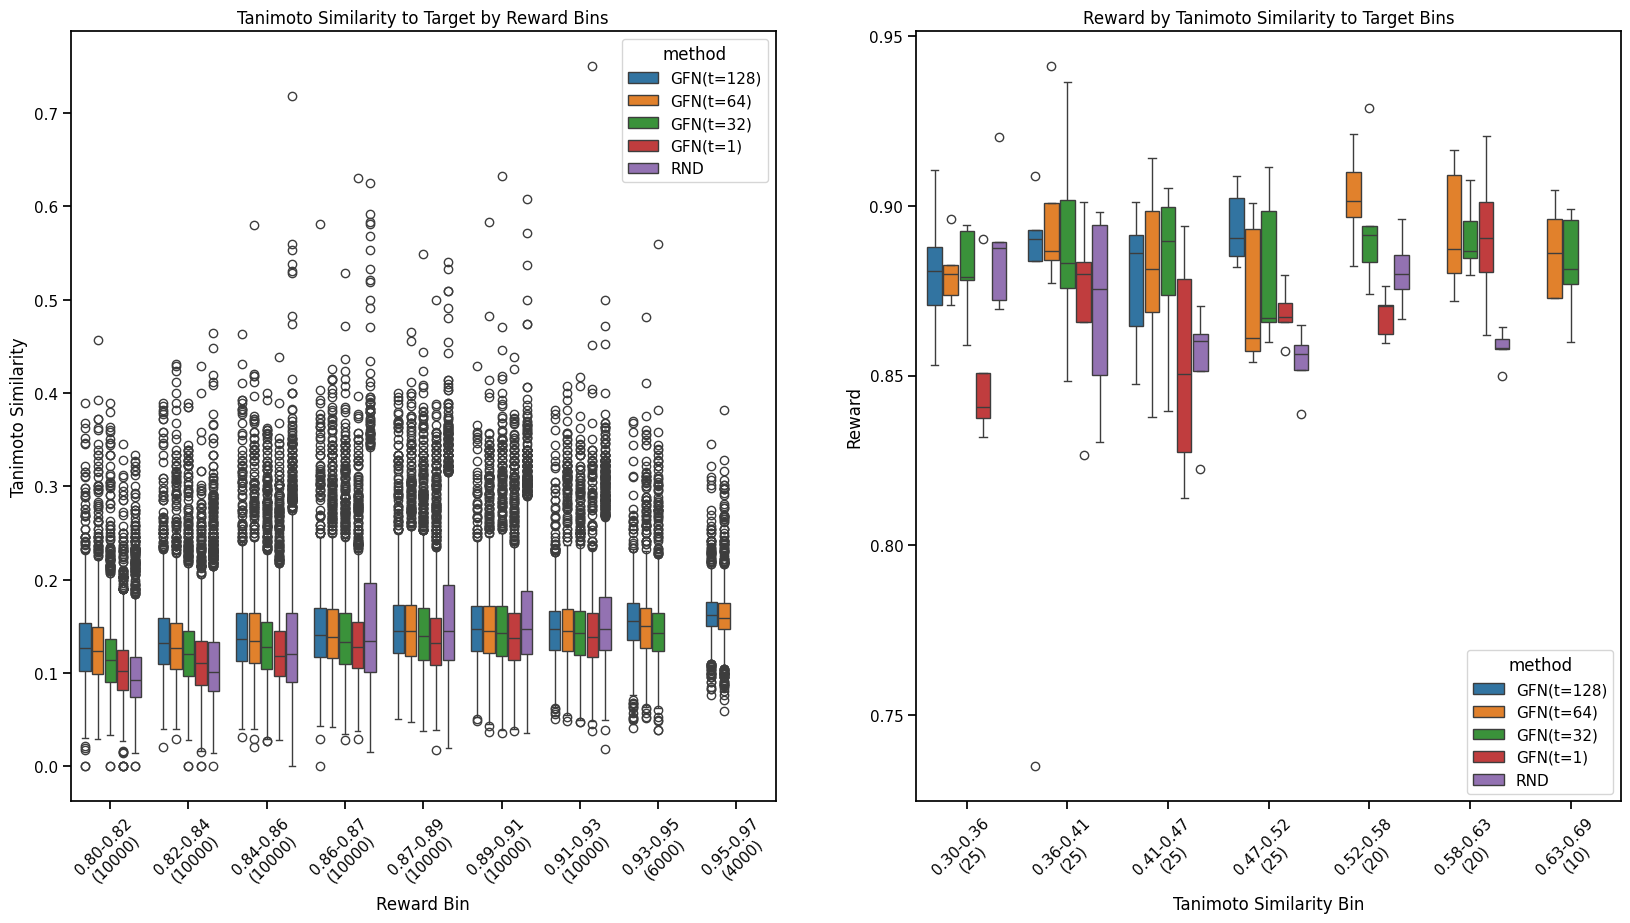

In [16]:
ignore_runs = ['PUMA_test']
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col("rewards", runs_datum,
    10, bin_min=0.8, return_bins=True, samples_per_method=2000, ignore_runs=ignore_runs)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col("sim_to_target", runs_datum,
    10, bin_min=0.3, return_bins=True, samples_per_method=5, ignore_runs=ignore_runs)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_ne)]
rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sns.boxplot(x="Bin", y="sim_to_target", hue="method", data=global_df_by_rew, ax=ax[0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_ne)]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]
sns.boxplot(x="Bin", y="rewards", hue="method", data=global_df_by_sim, ax=ax[1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0].set_title("Tanimoto Similarity to Target by Reward Bins")
ax[0].set_xlabel("Reward Bin")
ax[0].set_ylabel("Tanimoto Similarity")
ax[0].xaxis.set_tick_params(rotation=45)

ax[1].set_title("Reward by Tanimoto Similarity to Target Bins")
ax[1].set_xlabel("Tanimoto Similarity Bin")
ax[1].set_ylabel("Reward")
ax[1].xaxis.set_tick_params(rotation=45)

# plt.savefig('sim_by_rew_cutoff.png')
plt.show()

## 2. Assay and Cluster Prediction Plots
In this section, we produce plots that require an additional oracle. These include:
- Normalized histogram of active target assay predictions for training samples
- Regular histogram of active target assay predictions for top-k modes
- Normalized histogram of active target cluster predictions for training samples
- Regular histogram of active target cluster predictions for top-k modes
- Violin plot of active target assay predictions by binned reward
- Violin plot of active target assay predictions by binned Tanimoto similarity to target
- Violin plot of active target cluster predictions by binned reward
- Violin plot of active target cluster predictions by binned Tanimoto similarity

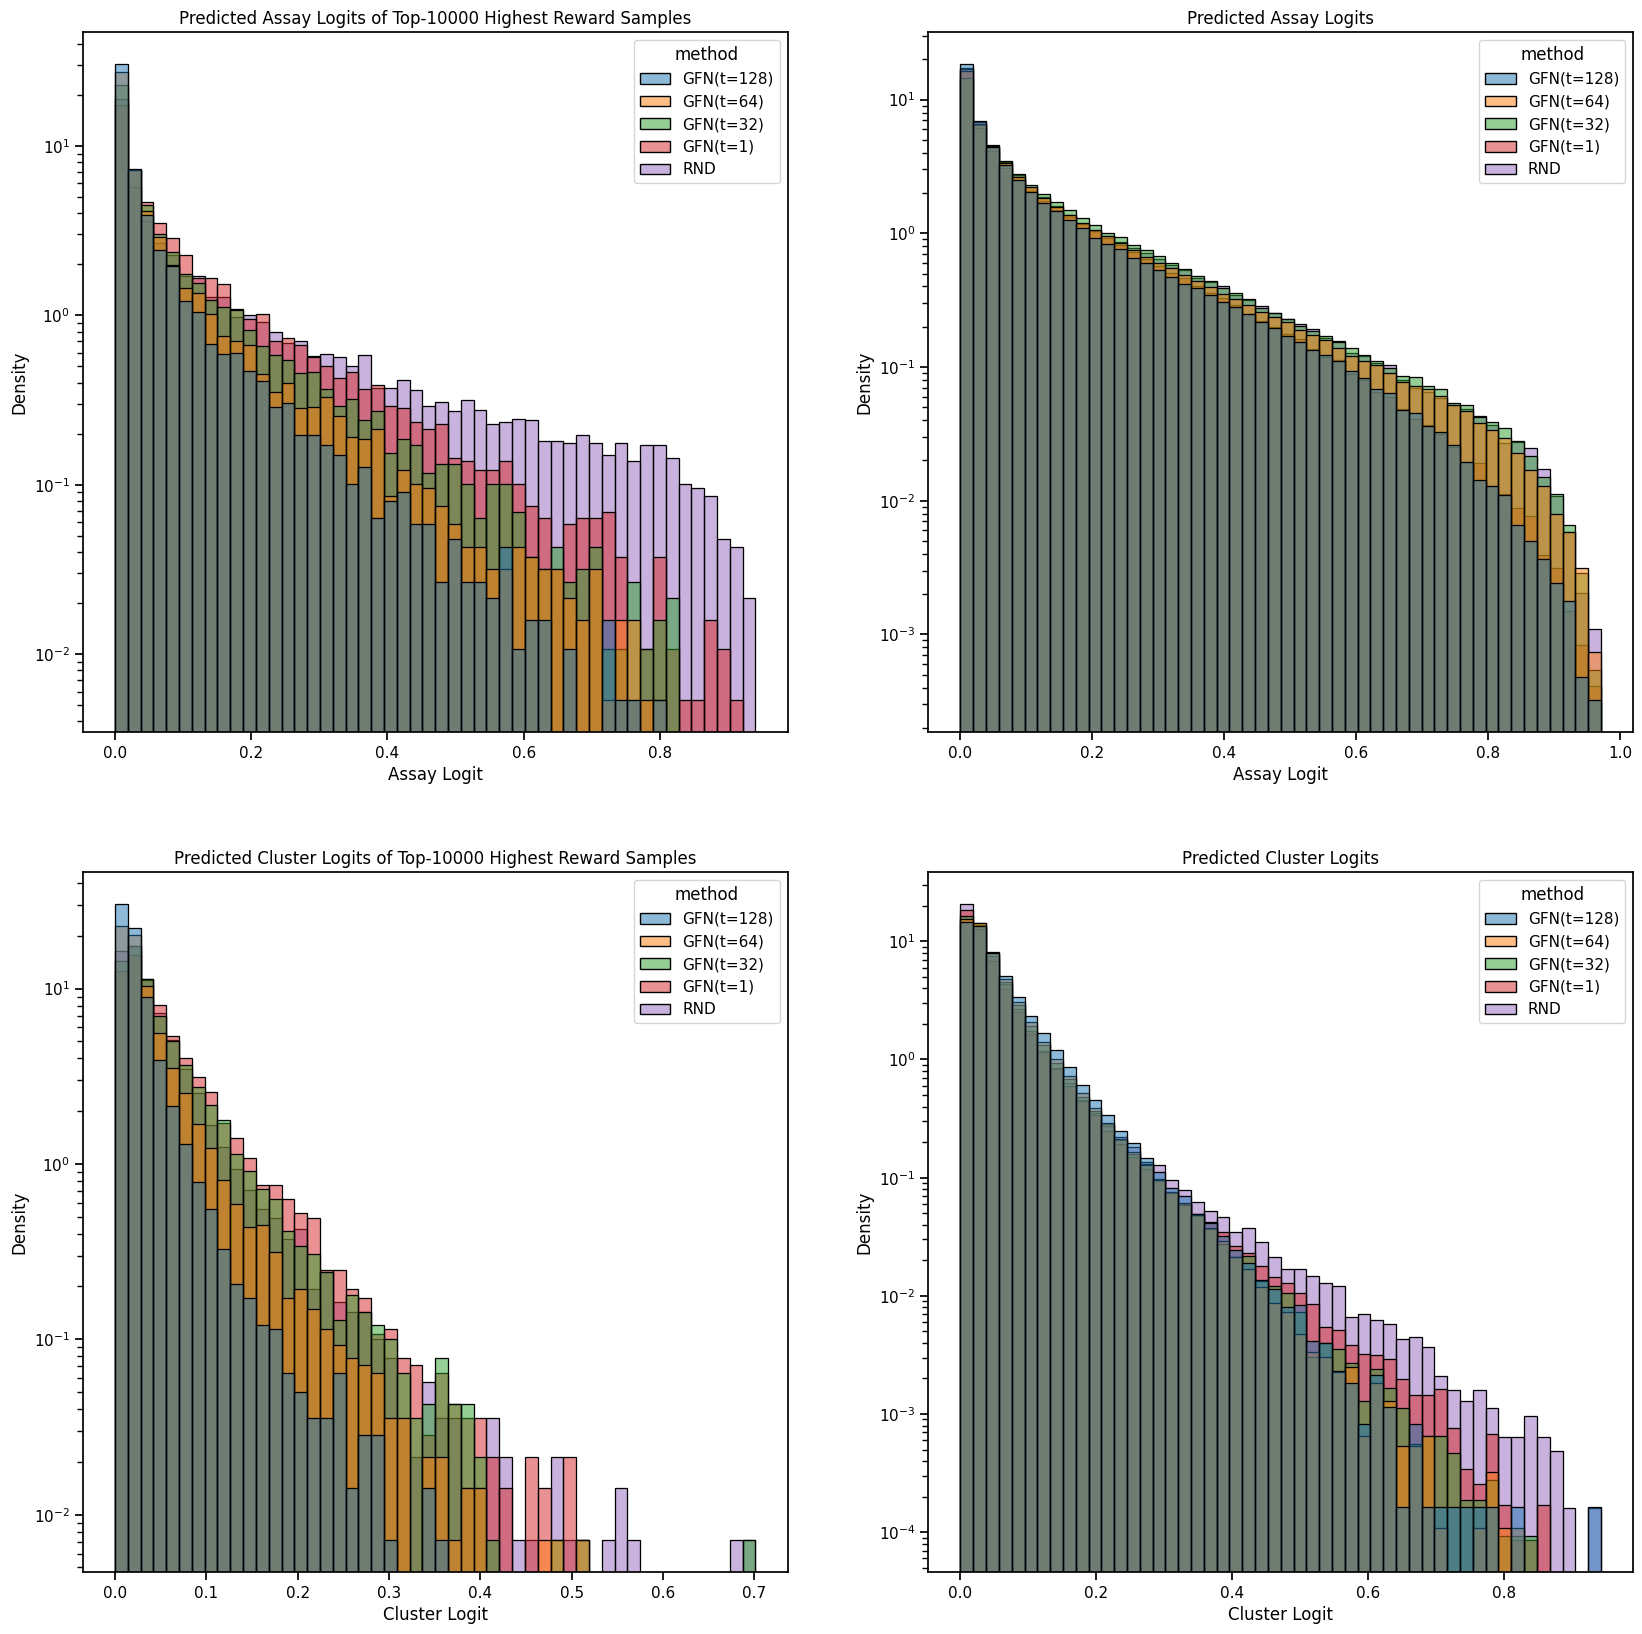

In [19]:
k = 10000
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
df1, df2 = pd.DataFrame(), pd.DataFrame()
for run_name, run_datum in runs_datum.items():
    if run_name in ["PUMA_test"]: continue
    if "assay_preds" not in run_datum.keys(): continue
    top_k_modes_idx = np.argsort(run_datum['rewards'])[::-1][:k]
    df1 = pd.concat([df1, pd.DataFrame({
        "method": [run_name] * len(top_k_modes_idx),
        "assay_preds": run_datum['assay_preds'][top_k_modes_idx],
        "cluster_preds": run_datum['cluster_preds'][top_k_modes_idx],
    })])
    df2 = pd.concat([df2, pd.DataFrame({
        "method": [run_name] * len(run_datum['assay_preds']),
        "assay_preds": run_datum['assay_preds'],
        "cluster_preds": run_datum['cluster_preds'],
    })])

sns.histplot(data=df1, x="assay_preds", hue="method", bins=50, ax=ax[0,0], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df2, x="assay_preds", hue="method", bins=50, ax=ax[0,1], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df1, x="cluster_preds", hue="method", bins=50, ax=ax[1,0], stat='density', alpha=0.5, common_norm=False)
sns.histplot(data=df2, x="cluster_preds", hue="method", bins=50, ax=ax[1,1], stat='density', alpha=0.5, common_norm=False)

ax[0,1].set_title("Predicted Assay Logits")
ax[0,0].set_title(f"Predicted Assay Logits of Top-{k} Highest Reward Samples")
ax[1,1].set_title("Predicted Cluster Logits")
ax[1,0].set_title(f"Predicted Cluster Logits of Top-{k} Highest Reward Samples")
ax[0,0].set_xlabel("Assay Logit")
ax[0,1].set_xlabel("Assay Logit")
ax[1,0].set_xlabel("Cluster Logit")
ax[1,1].set_xlabel("Cluster Logit")
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

# plt.savefig("proxy_preds_hist.png")
plt.show()

Binning rewards into 10 bins between 0.4108951985836029 and 0.9659846425056458: 
Bins: [0.4108952  0.4725718  0.53424841 0.59592501 0.65760162 0.71927822
 0.78095483 0.84263143 0.90430804 0.96598464]
Sampling 2000 samples per method per bin
Binning sim_to_target into 10 bins between 0.0 and 0.8: 
Bins: [0.         0.08888889 0.17777778 0.26666667 0.35555556 0.44444444
 0.53333333 0.62222222 0.71111111 0.8       ]
Sampling 1200 samples per method per bin


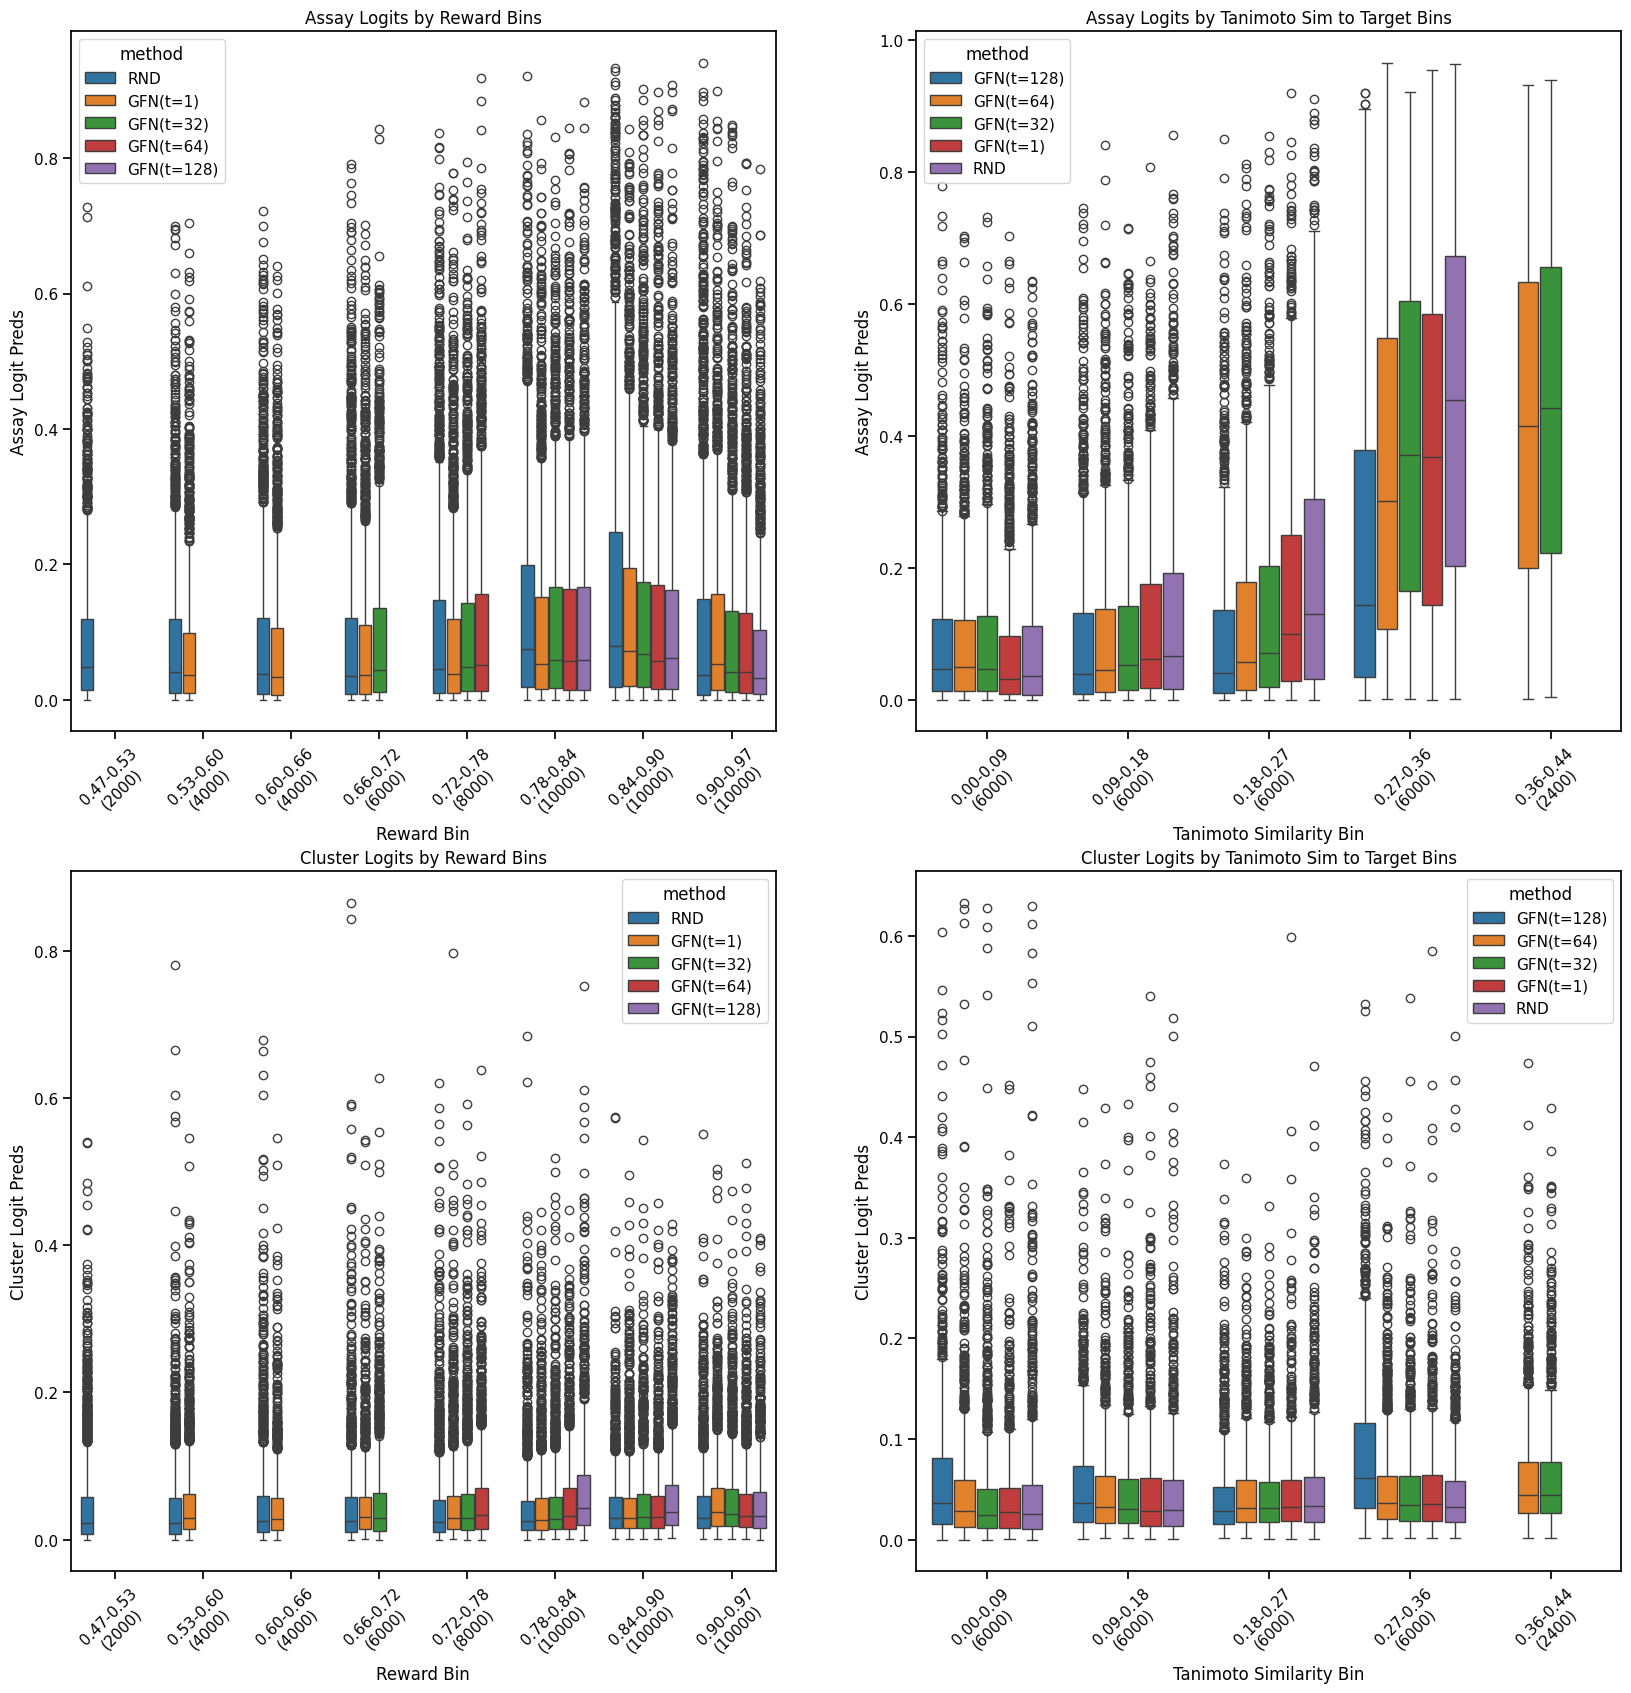

In [20]:
ignore_runs = ['PUMA_test']
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col(
    "rewards", runs_datum, 10, return_bins=True, samples_per_method=2000, ignore_runs=ignore_runs)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col(
    "sim_to_target", runs_datum, 10, return_bins=True, samples_per_method=1200, ignore_runs=ignore_runs)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    # if run_name != "RND": continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]

# Only keep the top 10 bins with values
rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
rew_bins_to_keep = rew_bins_ne[:5] + rew_bins_ne[-5:]
sim_bins_to_keep = sim_bins_ne[:5] + sim_bins_ne[-5:]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_to_keep)]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_to_keep)]

sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_rew, ax=ax[0,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_sim, ax=ax[0,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_rew, ax=ax[1,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_sim, ax=ax[1,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0,0].set_title("Assay Logits by Reward Bins")
ax[0,0].set_xlabel("Reward Bin")
ax[0,0].set_ylabel("Assay Logit Preds")
ax[0,0].xaxis.set_tick_params(rotation=45)
ax[0,1].set_title("Assay Logits by Tanimoto Sim to Target Bins")
ax[0,1].set_xlabel("Tanimoto Similarity Bin")
ax[0,1].set_ylabel("Assay Logit Preds")
ax[0,1].xaxis.set_tick_params(rotation=45)

ax[1,0].set_title("Cluster Logits by Reward Bins")
ax[1,0].set_xlabel("Reward Bin")
ax[1,0].set_ylabel("Cluster Logit Preds")
ax[1,0].xaxis.set_tick_params(rotation=45)
ax[1,1].set_title("Cluster Logits by Tanimoto Sim to Target Bins")
ax[1,1].set_xlabel("Tanimoto Similarity Bin")
ax[1,1].set_ylabel("Cluster Logit Preds")
ax[1,1].xaxis.set_tick_params(rotation=45)

# plt.savefig("proxy_preds_boxplot.png")
plt.show()

Binning rewards into 15 bins between 0.33327290415763855 and 0.9659846425056458: 
Bins: [0.3332729  0.3784666  0.4236603  0.46885399 0.51404769 0.55924138
 0.60443508 0.64962877 0.69482247 0.74001616 0.78520986 0.83040356
 0.87559725 0.92079095 0.96598464]
Sampling 2000 samples per method per bin
Binning sim_to_target into 15 bins between 0.0 and 0.8: 
Bins: [0.         0.05714286 0.11428571 0.17142857 0.22857143 0.28571429
 0.34285714 0.4        0.45714286 0.51428571 0.57142857 0.62857143
 0.68571429 0.74285714 0.8       ]
Sampling 2000 samples per method per bin


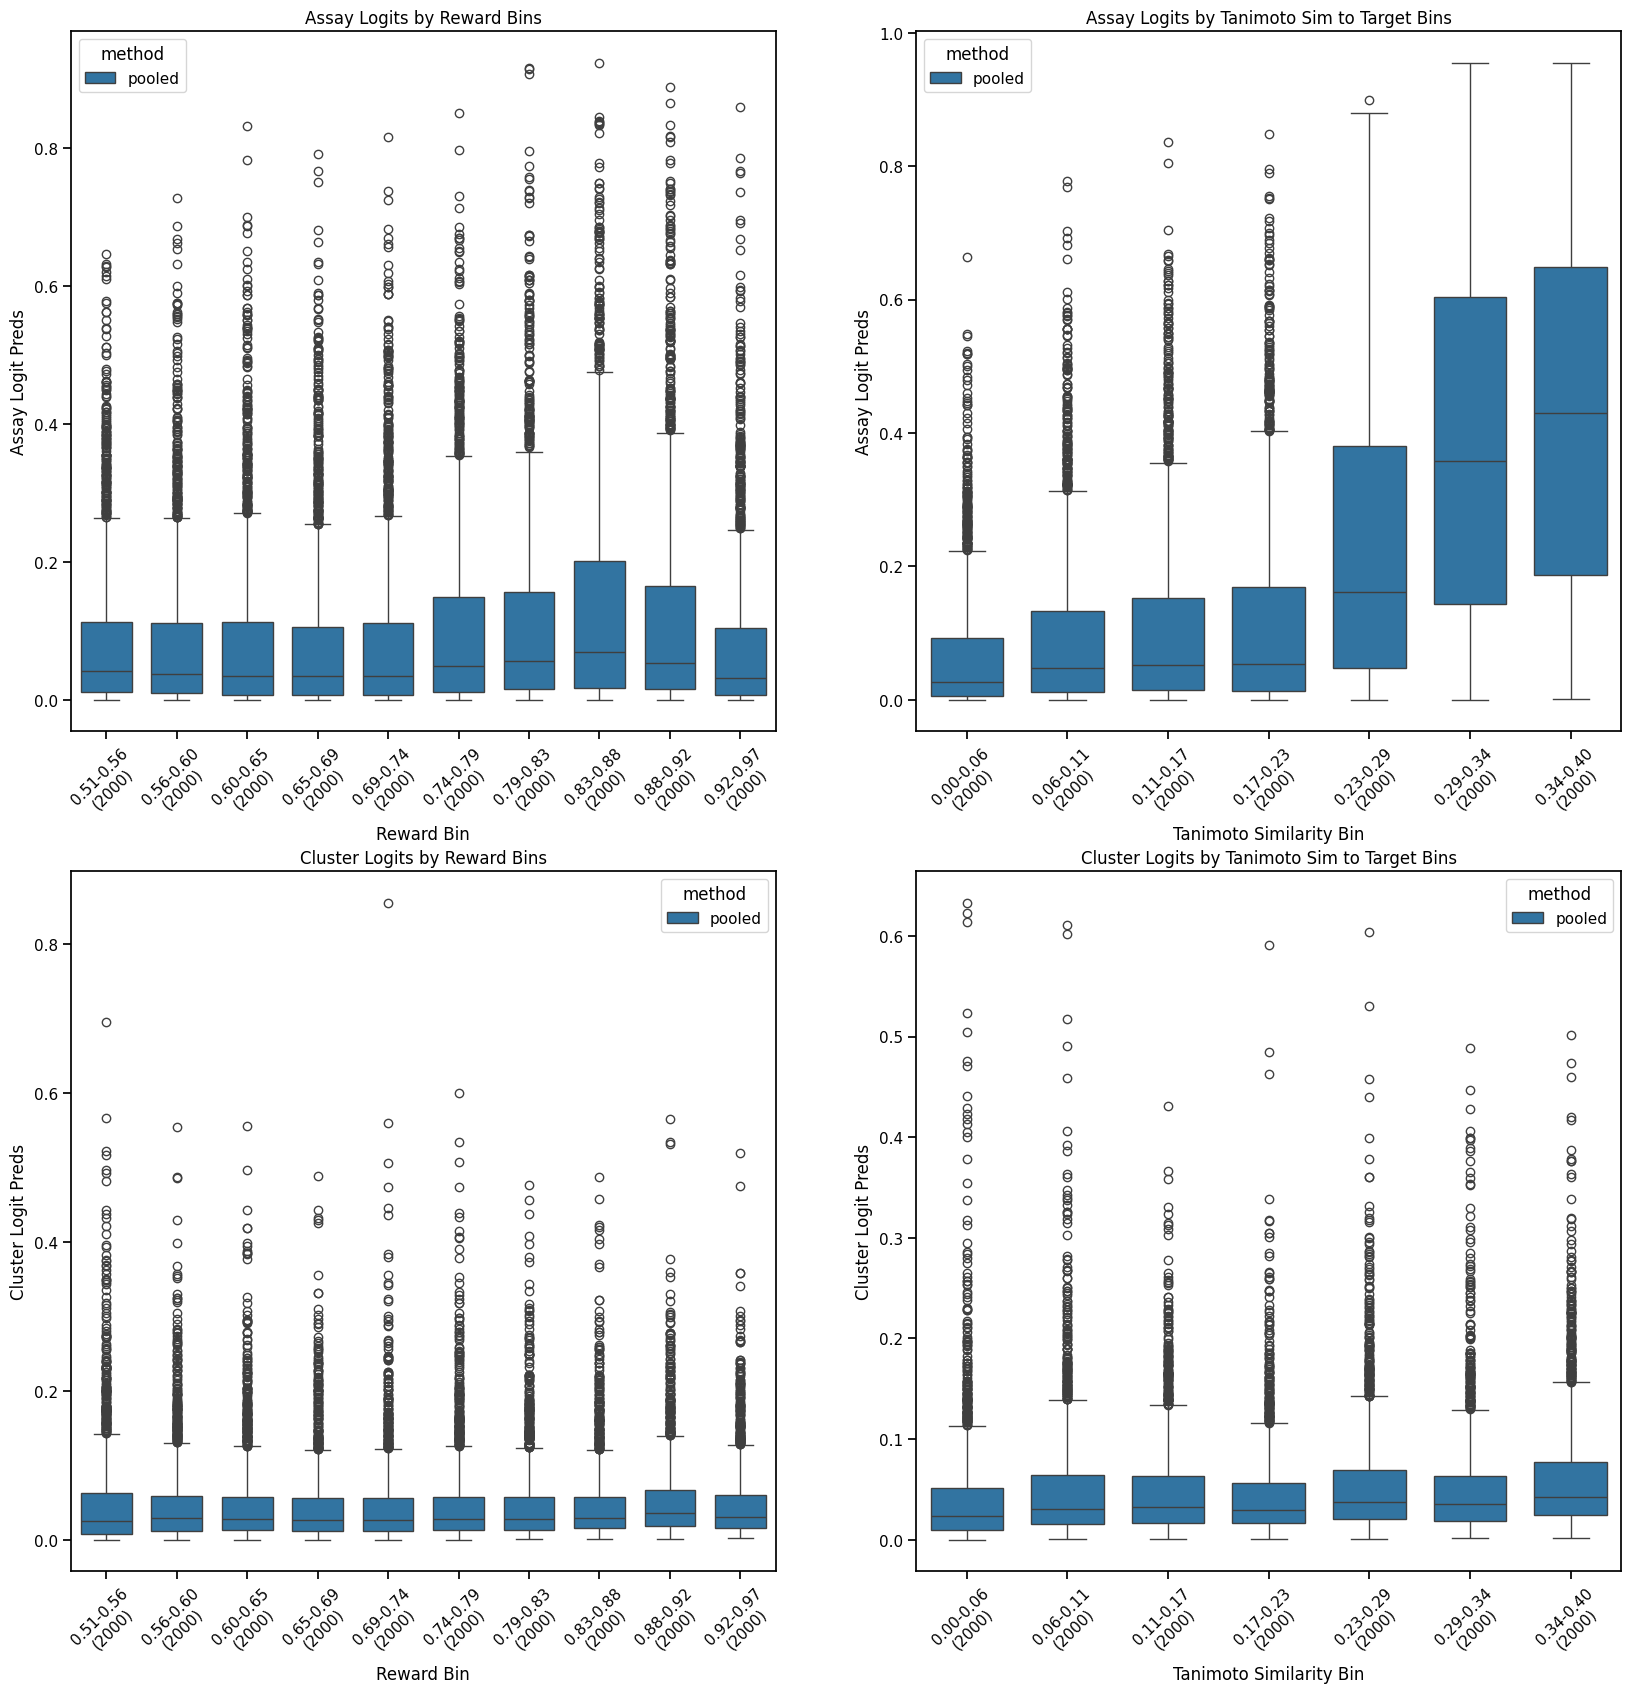

In [23]:
# Create a pooled datum where we merge the datum for each run under a new key called 'pooled'
pooled_datum = pool_datum(runs_datum, avoid_keys=["PUMA_tr", "PUMA_val"])
binned_datum_by_reward, rew_bins, rew_empty_bins, sper_rew_bin = bin_datum_by_col(
    "rewards", pooled_datum, 15, return_bins=True, samples_per_method=2000, toss_bins_with_less_methods=True)
binned_datum_by_tan_sim, sim_bins, sim_empty_bins, sper_sim_bin = bin_datum_by_col(
    "sim_to_target", pooled_datum, 15, return_bins=True, samples_per_method=2000, toss_bins_with_less_methods=True)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
global_df_by_rew = pd.DataFrame()
global_df_by_sim = pd.DataFrame()

for run_name, run_datum in binned_datum_by_reward.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    # if run_name != "RND": continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_rew = pd.concat([global_df_by_rew, df], ignore_index=True)

for run_name, run_datum in binned_datum_by_tan_sim.items():
    if run_name in ["PUMA_tr", "PUMA_val"]: continue
    dfs = [pd.DataFrame({**{'Bin': bin}, **subdict}) for bin, subdict in run_datum.items()]
    if len(dfs) == 0: continue
    df = pd.concat(dfs, ignore_index=True)
    df["method"] = run_name
    global_df_by_sim = pd.concat([global_df_by_sim, df], ignore_index=True)

rew_bin_labels = [f"{rew_bins[i]:.2f}-{rew_bins[i+1]:.2f}\n({sper_rew_bin[i]})"
                    for i in range(len(rew_bins)-1)] + [f"{rew_bins[-1]:.2f}-1.0\n({sper_rew_bin[-1]})"]
sim_bin_labels = [f"{sim_bins[i]:.2f}-{sim_bins[i+1]:.2f}\n({sper_sim_bin[i]})"
                    for i in range(len(sim_bins)-1)] + [f"{sim_bins[-1]:.2f}-1.0\n({sper_sim_bin[-1]})"]

# Only keep the top 10 bins with values
rew_bins_ne = [i for i in range(1, len(rew_bins)+1) if i not in rew_empty_bins]
sim_bins_ne = [i for i in range(1, len(sim_bins)+1) if i not in sim_empty_bins]
rew_bins_to_keep = rew_bins_ne[:5] + rew_bins_ne[-5:]
sim_bins_to_keep = sim_bins_ne[:5] + sim_bins_ne[-5:]
global_df_by_rew = global_df_by_rew[global_df_by_rew['Bin'].isin(rew_bins_to_keep)]
global_df_by_sim = global_df_by_sim[global_df_by_sim['Bin'].isin(sim_bins_to_keep)]

sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_rew, ax=ax[0,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="assay_preds", hue="method", data=global_df_by_sim, ax=ax[0,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_rew, ax=ax[1,0],\
               formatter=lambda x: rew_bin_labels[int(x)-1], gap=.1)
sns.boxplot(x="Bin", y="cluster_preds", hue="method", data=global_df_by_sim, ax=ax[1,1],\
               formatter=lambda x: sim_bin_labels[int(x)-1], gap=.1)

ax[0,0].set_title("Assay Logits by Reward Bins")
ax[0,0].set_xlabel("Reward Bin")
ax[0,0].set_ylabel("Assay Logit Preds")
ax[0,0].xaxis.set_tick_params(rotation=45)
ax[0,1].set_title("Assay Logits by Tanimoto Sim to Target Bins")
ax[0,1].set_xlabel("Tanimoto Similarity Bin")
ax[0,1].set_ylabel("Assay Logit Preds")
ax[0,1].xaxis.set_tick_params(rotation=45)

ax[1,0].set_title("Cluster Logits by Reward Bins")
ax[1,0].set_xlabel("Reward Bin")
ax[1,0].set_ylabel("Cluster Logit Preds")
ax[1,0].xaxis.set_tick_params(rotation=45)
ax[1,1].set_title("Cluster Logits by Tanimoto Sim to Target Bins")
ax[1,1].set_xlabel("Tanimoto Similarity Bin")
ax[1,1].set_ylabel("Cluster Logit Preds")
ax[1,1].xaxis.set_tick_params(rotation=45)

# plt.savefig("pooled_proxy_preds_boxplot.png")
plt.show()